In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress,t
from scipy import stats
import math

def plot_data_theory(datafile, x_col, y_col, theory_col='', title='', x_label='', y_label='', x_unit='', y_unit='', x_error=0.0, y_error=0.0, theory_error=0.0, no_reg = False, desc = '',ytype='linear',xtype='linear'):
    df = pd.read_excel('data/'+datafile+'.xlsx')

    x = df[x_col]
    y = df[y_col]

    # Create figure and axes
    fig, ax = plt.subplots()
    plt.yscale(ytype)
    plt.xscale(xtype)

    if theory_col != '':
        theory = df[theory_col]
        # Add theoretical data to the plot
        ax.plot(x, theory, '-', label='Théorique', lw=1, color='orange')

    if not no_reg:
        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        a = slope

        # Calcul de l'incertitude sur la pente
        delta_slope = get_delta_slope(x,y,x_error,y_error)
        ax.text(0.95, 0.05, f'a = {a:.2e} +- {delta_slope:.2e}', transform=ax.transAxes, ha='right')

        # Add linear regression to the plot
        x_reg = np.linspace(x.min(), x.max(), 100)
        y_reg = slope * x_reg + intercept
        ax.plot(x_reg, y_reg, '--', label=f'Régression linéaire: f(x)=ax+b', lw=1, color='cyan')

        # Add R^2 value to the plot
        ax.text(0.05, 0.95, f'$R^2 = {r_value**2:.2f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Add data points to the plot
    if desc == '':
        ax.plot(x, y, 'o', label='Données expérimentales', ms=5, mec='cyan', mew=1)
    else:
        ax.plot(x, y, 'o', label=desc, ms=5, mec='cyan', mew=1)

    # Add axis labels and title
    ax.set_xlabel(x_label + ' (' + x_unit + ')')
    ax.set_ylabel(y_label + ' (' + y_unit + ')')
    ax.set_title(title)

    # Add legend
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # Add error bars
    if x_error > 0:
        ax.errorbar(x, y, xerr=x_error, fmt='none', capsize=3, ecolor='cyan')
    if y_error > 0:
        ax.errorbar(x, y, yerr=y_error, fmt='none', capsize=3, ecolor='cyan')
    if theory_error > 0:
        ax.errorbar(x, theory, yerr=theory_error, fmt='none', capsize=2, ecolor='orange')

    # Add power of 10 scale to axes
    ax.yaxis.set_major_formatter('{x:.1e}')
    ax.xaxis.set_major_formatter('{x:.1e}')

    plt.show()

def get_delta_slope(x,y,x_err,y_err):
    n = np.size(x)-1
    x1max = x[0] + x_err
    y1max = y[0] - y_err
    x2max = x[n] - x_err
    y2max = y[n] + y_err

    slopemax = (y2max-y1max)/(x2max-x1max)

    x1min = x[0] - x_err
    y1min = y[0] + y_err
    x2min = x[n] + x_err
    y2min = y[n] - y_err

    slopemin = (y2min-y1min)/(x2min-x1min)

    final = abs(slopemax-slopemin)
    final /= 2
    return final

def get_incertitude(tab_val,cst):
    """
    Permet de récupérer les valeurs d'incertitudes d'une équation prenant plusieurs variables
    :param cst: constante à laquelle multiplier le final
    :param tab_val: [(valeur,incertitude_absolue,puissance),...]
    :return: tuple (valeur_finale,incertitude_finale)
    """
    valeur_finale = cst
    incertitude_finale = 0

    for val,inc_abs,puiss in tab_val:
        valeur_finale *= val**puiss
        incertitude_finale += (puiss*inc_abs/val)**2
    incertitude_finale = valeur_finale * np.sqrt(incertitude_finale)

    return valeur_finale,incertitude_finale

def get_resistivity_from_length(slope, delta_slope, diameter, delta_diameter):
    #Permet d'obtenir la resistivité
    return get_incertitude([(slope,delta_slope,1),(diameter,delta_diameter,2)],math.pi/4)

def get_resistivity_from_diameter(slope, delta_slope, length,delta_length):
    #Permet d'obtenir la resistivité
    return get_incertitude([(slope,delta_slope,1),(length,delta_length,-1)],math.pi/4)

In [41]:
#Test pour une valeur connue
get_incertitude([(1.52,0.02,2),(156,5,-1)],1)

(0.01481025641025641, 0.000614189289599054)

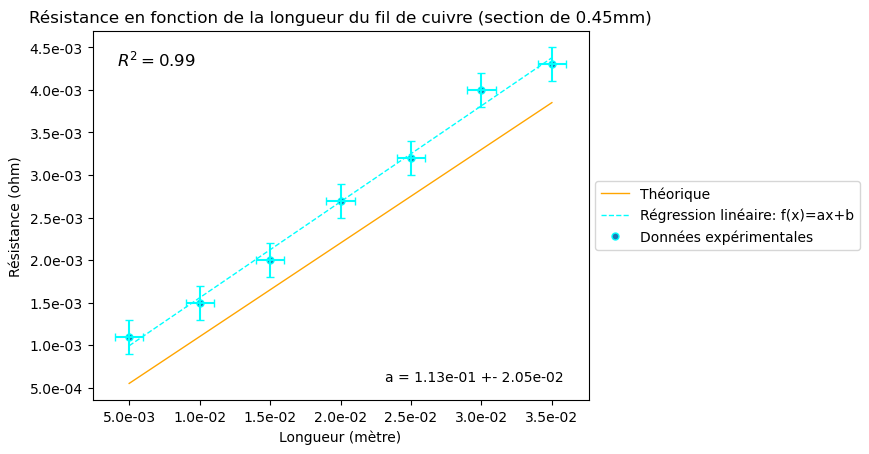

(1.797187347394211e-08, 3.3567999794361256e-09)


In [42]:
# appel de la fonction pour tracer le graphique pour 0.45 mm de section de cuivre
plot_data_theory('data045', 'Longueur', 'Resistance', 'Theorique',
                  title='Résistance en fonction de la longueur du fil de cuivre (section de 0.45mm)',
                  x_label='Longueur', y_label='Résistance',x_unit='mètre',y_unit='ohm',x_error=0.001,y_error=0.0002)
print(get_resistivity_from_length(0.113,0.0205,0.00045,0.00001))

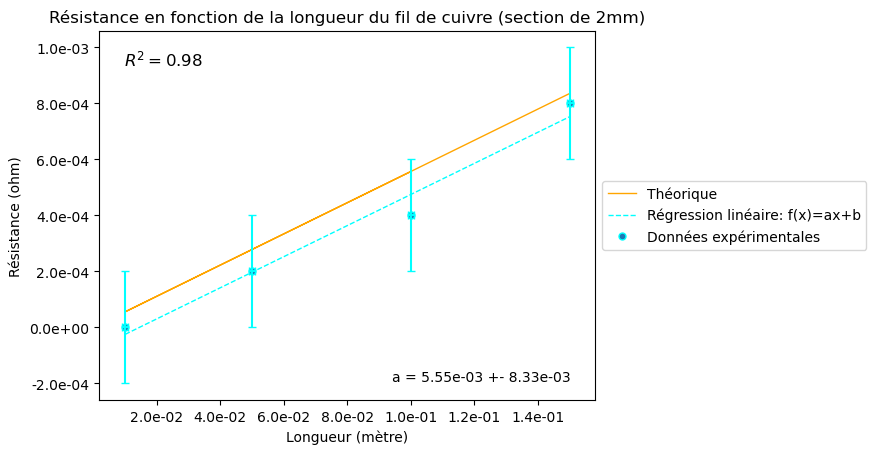

(1.7435839227423353e-08, 2.6170047643741613e-08)


In [44]:
# appel de la fonction pour tracer le graphique pour 2 mm de section de cuivre
plot_data_theory('data2', 'Longueur', 'Resistance', 'Theorique',
                  title='Résistance en fonction de la longueur du fil de cuivre (section de 2mm)',
                  x_label='Longueur', y_label='Résistance',x_unit='mètre',y_unit='ohm',x_error=0.001,y_error=0.0002)
print(get_resistivity_from_length(0.00555,0.00833,0.002,0.00001))

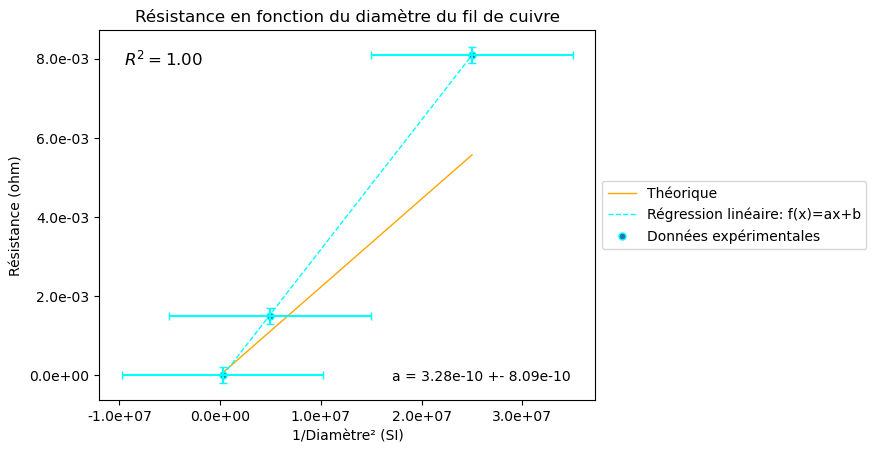

(2.5761059759436304e-08, 6.359091264298417e-08)


In [48]:
# appel de la fonction pour tracer le graphique pour le diamètre avec un fil de 1mm de long
plot_data_theory('data_diam', 'Diametre^-2', 'Resistance', 'Theorique',
                  title='Résistance en fonction du diamètre du fil de cuivre',
                  x_label='1/Diamètre²', y_label='Résistance',x_unit='SI',y_unit='ohm',x_error=10000000,y_error=0.0002)
print(get_resistivity_from_diameter(0.000000000328,0.000000000809,0.01,0.001))

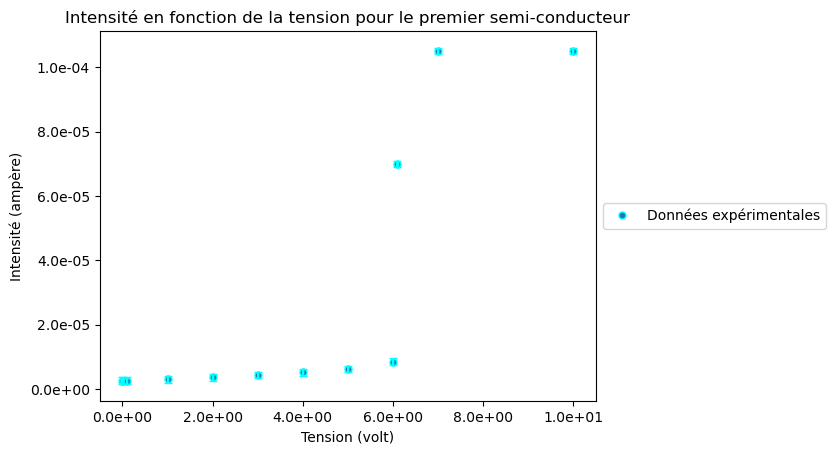

In [49]:
# appel de la fonction pour tracer le graphique pour intensité en fonction de la tension pour le premier semi
plot_data_theory('data_semi', 'Tension', 'Intensité',
                  title='Intensité en fonction de la tension pour le premier semi-conducteur',
                  x_label='Tension', y_label='Intensité',x_unit='volt',y_unit='ampère',x_error=0.0005,y_error=0.000001,no_reg = True)

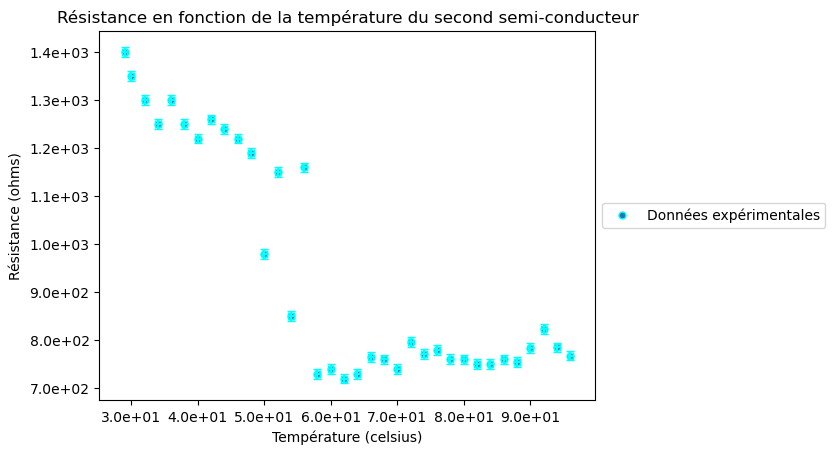

In [50]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour le deuxième semi
plot_data_theory('data_temp_semi2', 'Temp', 'Ohms',
                 title='Résistance en fonction de la température du second semi-conducteur',
                 x_label='Température', y_label='Résistance', x_unit='celsius', y_unit='ohms', x_error=0.4,
                 y_error=10, no_reg=True)

ValueError: too many values to unpack (expected 1)

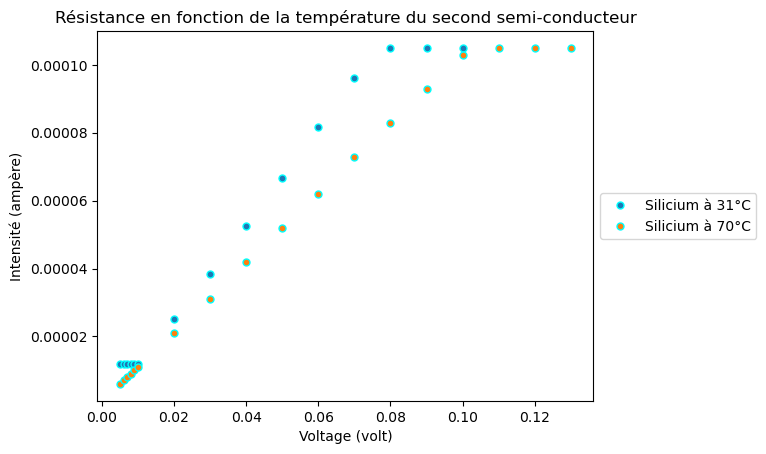

In [51]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour le deuxième semi
plot_data_theory('data_difftemp_vi', ['V31','V70'], ['I31','I70'],
                 desc = ['Silicium à 31°C','Silicium à 70°C'],
                 title='Résistance en fonction de la température du second semi-conducteur',
                 x_label='Voltage', y_label='Intensité', x_unit='volt', y_unit='ampère', x_error=0.0001,
                 y_error=0.000001, no_reg=True)

In [52]:
# On calcule l'incertitude de la resistivité avec la formule p = R*pi*D²/(4l)
# On choisit ici l'incertitude globale sur la résistance et une valeur moyenne

get_incertitude([(0.011,0.0001,1),(0.0005,0.00001,2),(0.1,0.01,-1)],math.pi/4)

(2.1598449493429822e-08, 2.334496129837556e-09)

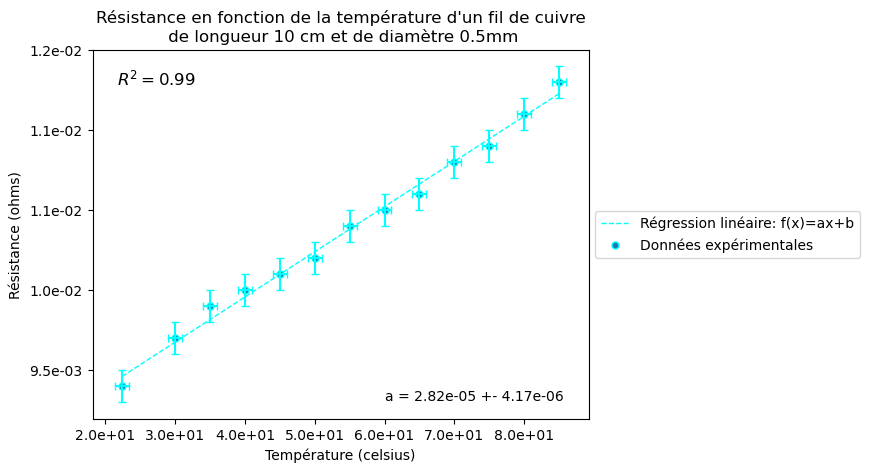

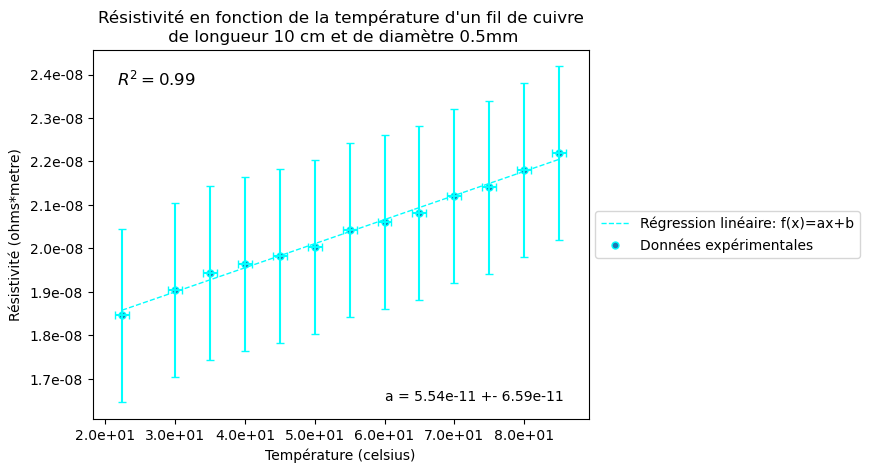

In [53]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour un fil de taille
plot_data_theory('data_cuivre_temp', 'Température', 'Résistance',
                 title="Résistance en fonction de la température d'un fil de cuivre\n de longueur 10 cm et de diamètre 0.5mm",
                 x_label='Température', y_label='Résistance', x_unit='celsius', y_unit='ohms', x_error=1,
                 y_error=0.0001)
plot_data_theory('data_cuivre_temp', 'Température', 'Resistivite',
                 title="Résistivité en fonction de la température d'un fil de cuivre\n de longueur 10 cm et de diamètre 0.5mm",
                 x_label='Température', y_label='Résistivité', x_unit='celsius', y_unit='ohms*metre',x_error=1,y_error=0.000000002) #On entre ici l'incertitude trouvée plus haut